# Project discrete optimization: a walk to the park

*Selected Topics in Mathematical Optimization: 2017-2018*

**Michiel Stock** ([email](michiel.stock@ugent.be))

![](Figures/logo.png)

YOUR NAME(S) HERE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

%matplotlib inline

blue = '#264653'
green = '#2a9d8f'
yellow = '#e9c46a'
orange = '#f4a261'
red = '#e76f51'
black = '#50514F'

In this project we will study a fictitious city (you can imagine it to be the capital of your favourite fantasy setting). A map of this city is given below.

![A city with streets and parks.](Figures/city_map.png)

Every point on this map is a crossing, and every grey line is a street between two crossings. Every street is a straight line and the length of the street is just the Euclidean distance between the two crossings.

This city also has some parks, indicated in green:

- **park A** at the top left corner;
- **park B** on the right, traversing top to bottom;
- **park C**, the little circular region in the middle.

This city can be represented as a weighted graph. Every vertex has an integer identifier and is associated with an $x,y$ coordinate. We have also three lists containing the indices of the vertices lying in the parks.

In [24]:
with open('Data/city.json', 'r') as fh:
    city = json.load(fh)
    
edges = list(map(tuple, city['edges']))
coordinates = city['coordinates']
vertices = list(city['vertices'])

park_A = city['parks']['A']
park_B = city['parks']['B']
park_C = city['parks']['C']

park_lst = ['A', 'B' , 'C']
parks = [city['parks'][park] for park in park_lst]

The main research question of this project is:

> What is the shortest path from *any* vertex to a vertex in a park?

As a first heuristic, we can use the minimum spanning tree on the graph. As seen in the theory, this is the tree tree that connects all vertices and has the lowest cost. From this tree, there is a single path from every edge to every other edge.

In a second step, we will use shortest path algorithms to find the true shortest path for every vertex.

**ASSIGNMENTS**

1. Find the minimum spanning tree for this graph.
    - Make a plot of the minimum spanning tree for this graph.
    - Compute the distance from any vertex on the minimum spanning tree to the closest vertex lying in a park.
    - Make a histogram of these distances (remove distances equal to zero, i.e. from vertices already in a park).
2. Compute the shortest distances from any vertex to the closest vertex (note that all shortest paths together will be a forest).
    - Implement this in an efficient way, **not** by using A* in a for-loop!
    - Show your solution on a plot, color the vertices according to the distances to the closest park and add arrows to indicate which vertex to take.
    - Show for every vertex whether park A, B or C is the closest.
    - Make a histogram of these distances (remove distances equal to zero, i.e. from vertices already in a park). Compare with the minimum spanning tree.

Some guidelines for completing this project:

- Write clear code with human-readable names and comments where needed. Add a (basic) docstring to all your functions.
- Make clear figures with ax labels, titles etc.
- Always provide some interpretation of the results.
- You **can** recycle and modify code from earlier chapters or other sources. Clearly indicate where you obtained this code from (you can add a hyperlink to the original source).

Finally, some hints that can help you do this project efficiently:

- Carefully read all assignments, assignment 1 and 2 essentially ask the same thing.
- The shortest path from vertex A to vertex B is the same as from vertex B to vertex A.
- If vertex C is on the shortest path from vertex A to vertex B, then you also found the shortest path from vertex C to vertex B. 

## The data

### Importing libraries

In [3]:
import heapq
from heapq import heapify, heappop, heappush
from numpy import inf
from numpy import sum as npsum

### Function definitions


In [8]:
# Lecture 05 Michiel's functions
def edges_to_adj_list(edges):
    """
    Turns a list of edges in an adjecency list (implemented as a list).
    Edges don't have to be doubled, will automatically be symmetric

    Input:
        - edges : a list of weighted edges (e.g. (0.7, 'A', 'B') for an
                    edge from node A to node B with weigth 0.7)

    Output:
        - adj_list : a dict of a set of weighted edges
    """
    adj_list = {}
    for w, i, j in edges:
        for v in (i, j):
            if v not in adj_list:
                adj_list[v] = set([])
        adj_list[i].add((w, j))
        adj_list[j].add((w, i))
    return adj_list

def adj_list_to_edges(adj_list):
    """
    Turns an adjecency list in a list of edges (implemented as a list).

    Input:
        - adj_list : a dict of a set of weighted edges

    Output:
        - edges : a list of weighted edges (e.g. (0.7, 'A', 'B') for an
                    edge from node A to node B with weigth 0.7)
    """
    edges = []
    for v, adjacent_vertices in adj_list.items():
        for w, u in adjacent_vertices:
            edges.append((w, u, v))
    return edges

# Lecture 05 my implementation 
def prim(vertices, edges, start, add_weights=False):
    """
    Prim's algorithm for finding a minimum spanning tree.

    Inputs :
        - vertices : a set of the vertices of the Graph
        - edges : a list of weighted edges (e.g. (0.7, 'A', 'B') for an
                    edge from node A to node B with weigth 0.7)
        - start : an edge to start with

    Output:
        - edges : a minumum spanning tree represented as a list of edges
        - total_cost : total cost of the tree
    """
    adj_list = edges_to_adj_list(edges)
    # list of tuples describing the edges starting from the start
    # vertix, with weights, i.e. the candidate edges
    to_check = [(w, start, v_new) for w, v_new in adj_list[start]]
    # heapify the list (~sorting)
    heapq.heapify(to_check)
    # for every node connected to the
    #dist_to_mst = {i : (w, start) for w, i in adj_list.pop(start)}
    mst_edges = []
    mst_vertices = set([start])
    total_cost = 0
    while to_check:
        # get the edge with the lowest cost connected to the vertix
        cost, v_in_mst, v_new = heapq.heappop(to_check)
        # check if the vertex is not in the current list of vertices
        # aka the path that is constructed
        if v_new not in mst_vertices:
            # if not, add to mst
            if add_weights:
                mst_edges.append((cost, v_in_mst, v_new))
            else:
                mst_edges.append((v_in_mst, v_new))
            mst_vertices.add(v_new)
            total_cost += cost
            # update the heap with candidate edges: adding the edges starting
            # from the newly added vertix
            for cost, v in adj_list[v_new]:
                heapq.heappush(to_check, (cost, v_new, v))    
    return mst_edges, total_cost

# A* Michiel stocks implementation we cannot possibly do it better
def a_star(graph, source, sink, heuristic):
    """
    Implementation of the A* shortest path algorithm.

    Inputs:
        - graph : dict representing the weighted graph
        - source : the source node
        - sink : the sink node (optional)
        - heuristic : a function with the heuristic for the shortest path
                    between two nodes

    Ouputs:
            - distance : dict with the distances of the nodes to the source
            - previous : dict with for each node the previous node in the
                        shortest path from the source
    """
    distance = {v : inf for v in graph.keys()}
    # vertices_to_check is a heap containing the estimated distance
    # of a given node to a source
    vertices_to_check = [(heuristic(source, sink), source)]
    previous = {}

    distance[source] = 0

    while vertices_to_check:
        heuristic_dist, current = heappop(vertices_to_check)
        if current == sink:
            return reconstruct_path(previous, source, sink), distance[sink]
        for dist_current_neighbor, neighbor in graph[current]:
            new_dist_from_source = distance[current] + dist_current_neighbor
            if new_dist_from_source < distance[neighbor]:
                distance[neighbor] = new_dist_from_source
                min_dist_neighbor_source = distance[neighbor] +\
                        heuristic(neighbor, sink)
                heappush(vertices_to_check, (min_dist_neighbor_source, neighbor))
                previous[neighbor] = current

def reconstruct_path(previous, source, sink):
    """
    Reconstruct the path from the output of the Dijkstra algorithm.

    Inputs:
            - previous : a dict with the previous node in the path
            - source : the source node
            - sink : the sink node
    Ouput:
            - the shortest path from source to sink
    """
    if sink not in previous:
        return []
    v = sink
    path = [v]
    while v is not source:
        v = previous[v]
        path = [v] + path
    return path

# Own imp.
def add_path(path, ax, color=red):
    """
    Add a path to an ax
    """
    for i in range(len(path)-1):
        i1, j1 = coordinates[path[i]]
        i2, j2 = coordinates[path[i+1]]
        ax.plot([i1, i2], [j1, j2], c=color, lw=2)

### Assignment 1

In [47]:
min_span_edge_lst, cost = prim(vertices=vertices,edges=edges,start=1, add_weights=True)
min_span_adj_lst = edges_to_adj_list(min_span_edge_lst)

NameError: name 'edge_list' is not defined

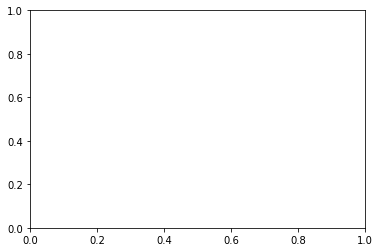

In [6]:
fig, ax = plt.subplots()
X = np.array(coordinates)
for i,j in edge_list:
    plt.plot([X[i,0],X[j,0]],[X[i,1],X[j,1]])

In [11]:
euclidean_distance = lambda x, y : sum([(xi - yi)**2 for xi, yi in zip(coordinates[x], coordinates[y])])**0.5

In [14]:
#path_astar,length_astar = a_star(min_span_adj_lst, source=0, sink=500, heuristic=euclidean_distance)
graph = edges_to_adj_list(edges)
path_astar,length_astar = a_star(graph=graph, source=0, sink=500, heuristic=euclidean_distance)

(0, 150)

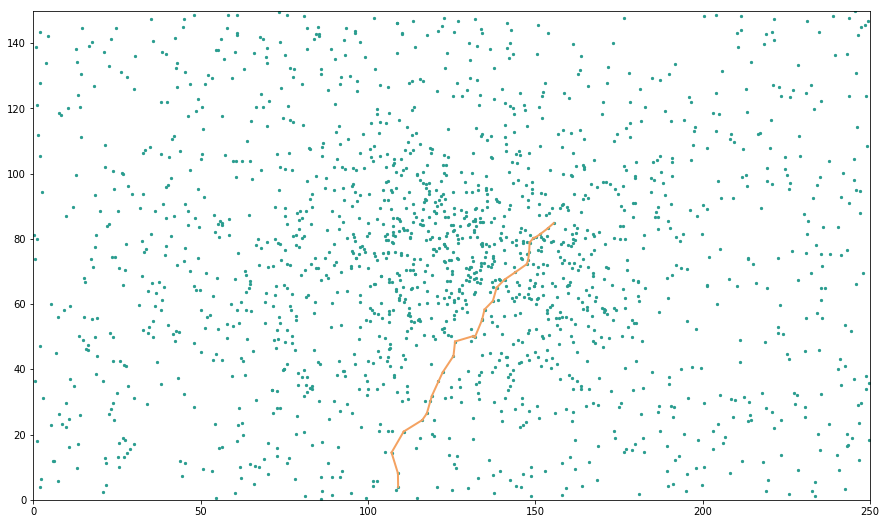

In [15]:
fig, ax = plt.subplots(figsize=(15,9))
X = np.array(coordinates)
# plot with links
ax.scatter(X[:,0], X[:,1], s=5, color=green, zorder=2)
add_path(path_astar, ax, orange)
ax.set_xlim(0,250)
ax.set_ylim(0,150)

In [ ]:
# YOUR CODE, PLOTS AND NOTES GO HERE

### Assignment 2

Pseudo code:

Get a list of all nodes that are on the edge of a park
For each vertice not in path:
    find closest park by finding closest vertice on edge of parth with euclidean distance


for all nodes that are not in a park


In [42]:
#def park_edge(edges):
 #daan

#def check_if_in_park(edge,park_A):
 #daan
    
def find_closest_park_vertice(vertice, vertices_park_edge, dist_measure):
    distance_lst = dist_measure(vertice,vertices_park_edge)
    mn,idx = min((distance_lst[i],i) for i in xrange(len(distance_lst)))
    return idx

def compute_shortest_path(graph):
    graph_queu = graph
    shortestpaths = {}
    while graph_queu:
        max_length = 1e10
        path_list = []
        source = graph.keys()[0]
        for park_edge_vertex in park_edge_vertices:
            temp_path_astar, temp_length_astar = path_ = a_star(graph=graph, source=source, sink=park_edge_vertex, heuristic=euclidean_distance)
            if temp_length_astar < max_length:
                path_list = temp_path_astar
                max_length = temp_length_astar
        
        shortestpaths[source:path_list]
        
        # delete all nodes 
        for vertex in path_list:
            del graph_queu[vertex]
            
        return shortestpaths

In [ ]:
euclidean_distance = lambda x, y : sum([(xi - yi)**2 for xi, yi in zip(coordinates[x], coordinates[y])])**0.5